## Vehicle Detection Project 

The project uses Machine Learning (ML) along with Computer Vision (CV) to detect surrounding vehicles. 
To successfully find vehicles we should reach following steps:
* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Apply a color transform and append binned color features, as well as histograms of color, to the HOG feature vector. 
* Implement a sliding-window technique and use the trained classifier to search for vehicles in images.
* Run the pipeline on a video stream and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [1]:
import matplotlib.pyplot as plt
import cv2
import os

from skimage.feature import hog
%matplotlib inline

### Configuration
After some experimentation I came up with following configs 

Image size: 64x64


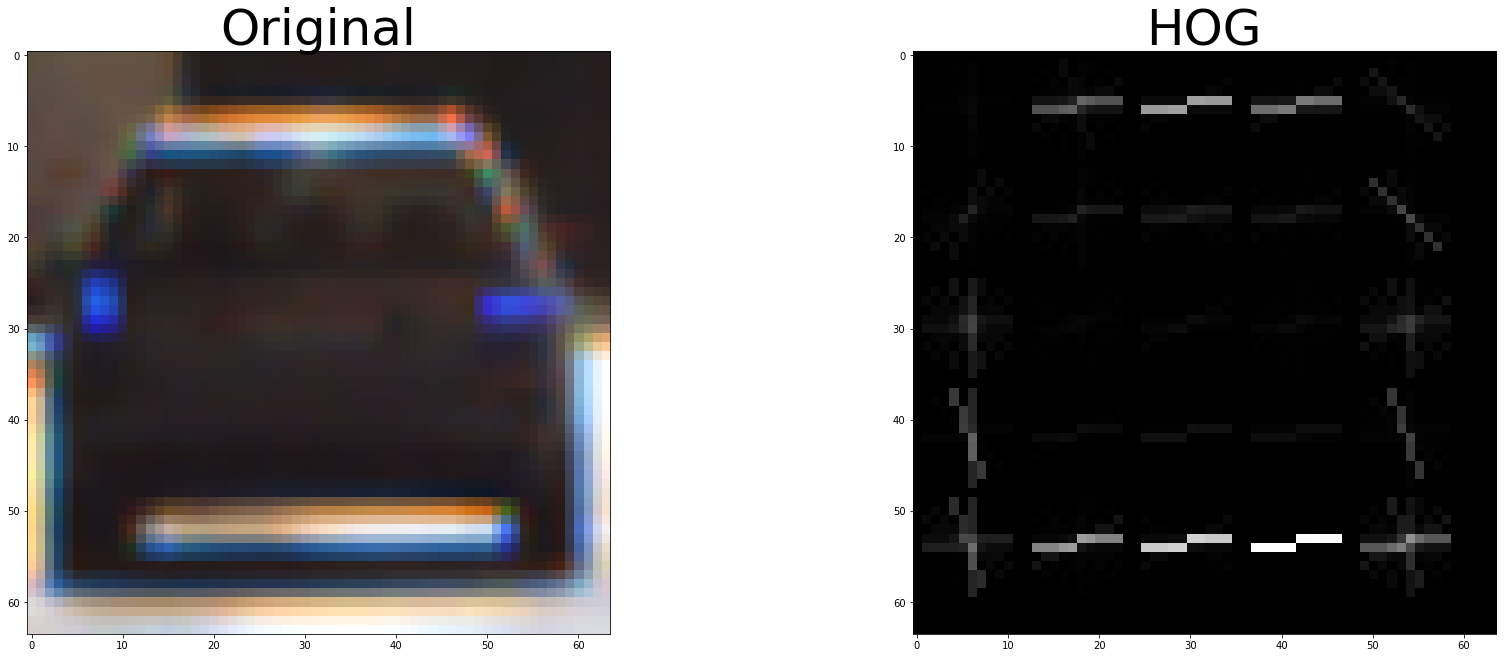

In [2]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 12 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 128    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [380, 656] # Min and max in y to search in slide_window()

# Just a helper function to plot titled images
def plot_inline(images, titles, figsize=(24, 9)):
    assert len(images) == len(titles)
    f, axs = plt.subplots(1, len(images), figsize=figsize)
    f.tight_layout()
    for i in range(0, len(images)):
        axs[i].imshow(images[i], cmap='gray')
        axs[i].set_title(titles[i], fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# The function reads data, could've used `glob` though
def read_data(path):
    acc = []
    for root, subs, files in os.walk(path):
        if subs:
            for sub in subs:
                read_data(sub)
        for file in files:
            if file.endswith('.png'):
                acc.append(os.path.join(root, file))
    return acc

# Testing HOG capabilities
def make_hog(img, visualise=True, feature_vector=True):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    l = hls[:,:,1]
    l = cv2.GaussianBlur(l, (5,5), 0)
    features, hog_image = hog(l,
                          orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell),
                          cells_per_block=(cell_per_block, cell_per_block),
                          visualise=visualise,
                          feature_vector=feature_vector
                         )
    return features, hog_image


vehicles = read_data('./data/vehicles')
non_vehicles = read_data('./data/non-vehicles')

test_img = cv2.imread(vehicles[3100])
test_hog = make_hog(test_img)
print('Image size: {}x{}'.format(test_img.shape[1], test_img.shape[0]))
plot_inline([test_img, test_hog[1]], ['Original', 'HOG'])

### Vehicle detection
First, we need to perform following steps:
- Define main functions to retrieve features
- Use a simple way to slide through a frame
- Use more advanced way to go from cell to cell to improve over all efficiency 

In [3]:
import numpy as np
from sklearn.preprocessing import StandardScaler

import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
from scipy.ndimage.measurements import label

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        feature_image = None
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

vehicles_features = extract_features(vehicles, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print('Processed: {} images, retrieved: {} features from vehicles list'
      .format(len(vehicles), len(vehicles_features)))

non_vehicles_features = extract_features(non_vehicles, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print('Processed: {} images, retrieved: {} features from non-vehicles list'
      .format(len(non_vehicles), len(non_vehicles_features)))

Processed: 8791 images, retrieved: 8791 features from vehicles list
Processed: 8968 images, retrieved: 8968 features from non-vehicles list


### Performing Normalization
To _Normalize_ an image I used `StandardScaler`
Below we can see the difference between _RAW_ and _Normalized_ images

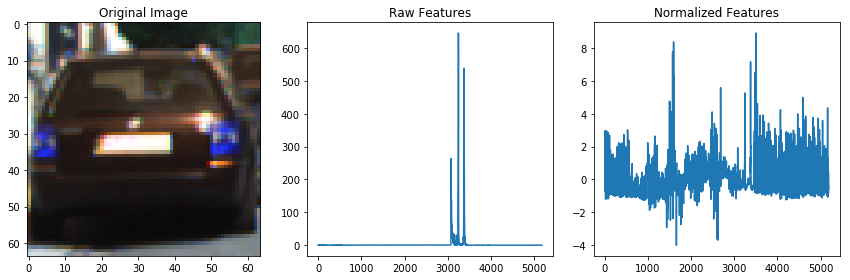

In [4]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

X = np.vstack((vehicles_features, non_vehicles_features)).astype(np.float64)                        
y = np.hstack((np.ones(len(vehicles_features)), np.zeros(len(non_vehicles_features))))

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

car_ind = np.random.randint(0, len(vehicles))
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(cv2.imread(vehicles[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()

### Training
To train our model I will use linear `SVC`. Despite that `hinge` loss is the default loss for `SVC` in `sklearn` I wrote it explicitly 

In [5]:
import time

def train(features, labels):
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=0.2, random_state=rand_state
    )
    print('Using spatial binning of:', spatial_size,
        'and', hist_bins,'histogram bins')
    print('Feature vector length:', len(X_train[0]))
    svc = LinearSVC(loss='hinge')

    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

    t=time.time()
    n_predict = 10
    print('My SVC predicts:  ', svc.predict(X_test[0:n_predict]))
    print('For these labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    return svc
    
import pickle

# svc = pickle.load('svc_pickle.p')['svc']
# if svc is None:
svc = train(scaled_X, y)

Using spatial binning of: (32, 32) and 128 histogram bins
Feature vector length: 5184
4.91 Seconds to train SVC...
Test Accuracy of SVC =  0.993
My SVC predicts:   [ 1.  1.  1.  1.  0.  1.  0.  0.  1.  0.]
For these labels:  [ 1.  1.  1.  1.  0.  1.  0.  0.  1.  0.]
0.00141 Seconds to predict 10 labels with SVC


### Sliding window
The simplest way to get parts of the image. Moving the window from start to end with determined overlap. The method can be considered inefficient

In [6]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars=
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

# function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    img_features = []
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
#         prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if svc.decision_function(test_features)[0] > 1.2:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

Found 20 calibration images
Processed 0 image
Processed 1 image
Processed 2 image
Processed 3 image
Processed 4 image
Processed 5 image
Processed 6 image
Processed 7 image
Processed 8 image
Processed 9 image
Processed 10 image
Processed 11 image
Processed 12 image
Processed 13 image
Processed 14 image
Processed 15 image
Processed 16 image
Processed 17 image
Processed 18 image
Processed 19 image
Finished processing all chessboard corners
Calibration finished


/Users/anechaev/Developer/SDC/CarND-Vehicle-Detection/lanelines.py:240: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  histogram = np.sum(image[y_window_top:y_window_bottom, :], axis=0)
/Users/anechaev/Developer/SDC/CarND-Vehicle-Detection/lanelines.py:289: RuntimeWarning: divide by zero encountered in double_scalars
  if abs((right - right_pre) / (right_pre - right_pre2) - 1) < .2:
/Users/anechaev/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/anechaev/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


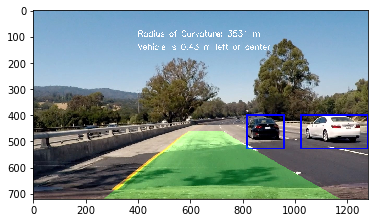

In [7]:
image = mpimg.imread('test_images/test4.jpg')

from lanelines import *
# from concurrent.futures import ThreadPoolExecutor

# pool = ThreadPoolExecutor()

def create_heatmap(image, windows, thresh=1):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat, windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 0)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    return labels


def process_image(image):
    draw_image = np.copy(image)
    draw_image = draw_image.astype(np.float32)/255

    y_min = 400
    y_max = 550
    y_start_stop = [y_min, y_max]

    windows = slide_window(draw_image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(64,64), xy_overlap=(0.7, 0.7))

#     y_min = 400
    y_max = 600
    y_start_stop = [y_min, y_max]

    windows.extend(
        slide_window(draw_image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(96,96), xy_overlap=(0.5, 0.5))
    )

#     y_min = 500
    y_max = 650
    y_start_stop = [y_min, y_max]

    windows.extend(
        slide_window(draw_image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(128,128), xy_overlap=(0.5, 0.5))
    )

    hot_windows = search_windows(draw_image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=6)
    
    labels = create_heatmap(image, hot_windows)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_lane_lines(draw_img)


processed_image = process_image(image)
plt.imshow(processed_image)

In [8]:
### Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
white_output = 'white.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 1260/1261 [38:26<00:02,  2.10s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 1h 30min 35s, sys: 2min 36s, total: 1h 33min 12s
Wall time: 38min 27s


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}"?>
</video>
""".format(white_output))

### Finding cars
The most important point at the project. 
Using the trained model I performed prediction for each selected frame
Instead of sliding windows with overlaping each other, I used HOG sub-sampling Window search discussed in the lectures.

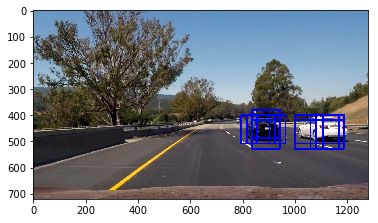

In [11]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, 'RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    bboxes = []
    search_area = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1,hog_feat2,hog_feat3)) 

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    

            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            search_area.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
            if svc.decision_function(test_features)[0] > 2.1:
                bboxes.append(
                    ((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart))
                )
    return bboxes, search_area
    
image = mpimg.imread('test_images/test6.jpg')

ystart = y_start_stop[0]
ystop = y_start_stop[1]
scale = 1.7
bboxes, search_area = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 2, spatial_size, hist_bins)
            
out_img = draw_boxes(image, bboxes)
# out_img = draw_boxes(out_img, search_area, color=(20, 150, 0))
plt.imshow(out_img)

In [12]:
# Saving model into a file. Can be done right after training. 
import pickle

filename = "svc_pickle.p"
handler = open(filename, "wb")
svc_dict = {
    'svc': svc,
    'scaler': X_scaler
}
pickle.dump(svc_dict, handler)

### Heatmap
To decrease number of Multiple detections and False Positive, I used heat map to define main region of intersection of all detected rectangles. 

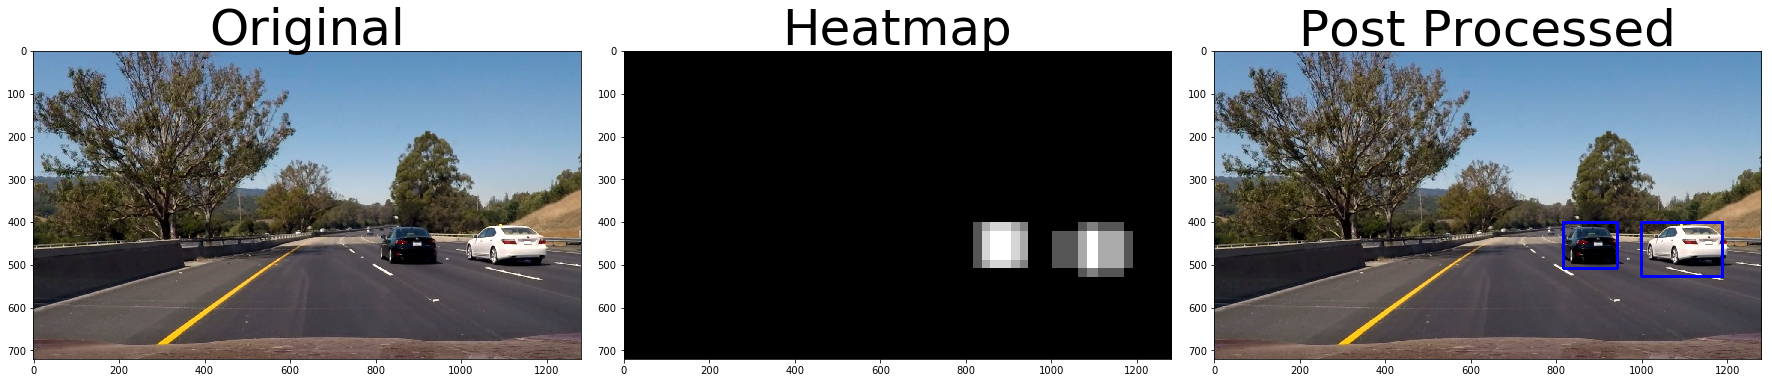

In [13]:
heat = np.zeros_like(image[:,:,0]).astype(np.float)
heat = add_heat(heat, bboxes)

# Apply threshold to help remove false positives
heat = apply_threshold(heat, 1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)
# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

plot_inline([image, heatmap, draw_img], ['Original', 'Heatmap', 'Post Processed'])

### Lane Lines + Vehicle detection
Using my work form the previous project, I combined Lane Lines and Vehicle detection algorithms.

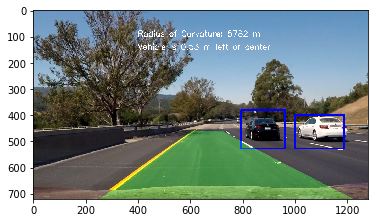

In [15]:
from lanelines import *
# from concurrent.futures import ThreadPoolExecutor

# pool = ThreadPoolExecutor()

def process_image(image):

    ystart = y_start_stop[0]
    ystop = y_start_stop[1]
    scale = 1.7
    bboxes, search_area = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 2, spatial_size, hist_bins)

    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat, bboxes)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    labels = create_heatmap(image, bboxes)
    labeled_image = draw_labeled_bboxes(np.copy(image), labels)
    return draw_lane_lines(labeled_image)

processed_img = process_image(image)
plt.imshow(processed_img)

In [16]:
### Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
white_output = 'white2.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white2.mp4
[MoviePy] Writing video white2.mp4


100%|█████████▉| 1260/1261 [19:44<00:00,  1.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white2.mp4 

CPU times: user 35min 5s, sys: 1min 50s, total: 36min 55s
Wall time: 19min 45s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))